## Overview

This script is used for the training of the main classifiers used in BALROG application and showcased in publication. For training the models we used Google Colab. This script is a adapted version of the training script used in the paper. You can inspect and run the setup in Google Colab, using this folder from google drive:
https://drive.google.com/drive/folders/1PoQCBq7t0R7cGMgllmFHxpwLHtMMs_Ds?usp=share_link

## Input Requirements
If you want to replicate the training locally you have to download the files from the `/classifier` here: 
https://drive.google.com/drive/folders/1KVqjOPV90UKcxodv_agUO3Tx2GYhggVd?usp=share_link

Required files (place in the `classifier/data` folder):

* `classifier/data/mos_dataset_processed.npy`
  Numpy array of processed image data with an alpha channel containing the background mask.

* `classifier/data/mos_dataset_labels.npy`
  Numpy array of integer labels corresponding to the images.

* `classifier/data/mos_dataset_folds.npy`
  Numpy array indicating fold assignments for cross-validation.

* `classifier/data/mos_dataset_paths.npy`
  Numpy array of image file paths (for reference).

## Outputs

* `classifier/models/*.pt`
The trained model as a .pt file. 

* `classifier/results/*.pkl`
Dataframe containing the paths and predictions of the model on the testing fold.

* `classifier/models/*.npy`
Numpy file which contains all the prediction of model on the testing fold.

## Usage Notes
You need to log in to weights and biases to use the script as it is. https://wandb.ai/site/

In [ ]:
import torch
import wandb
import math
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import albumentations as A

from sklearn.utils import compute_sample_weight
from sklearn.preprocessing import OneHotEncoder
import skimage as ski

import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# Set the working directory
os.chdir("..")
from utils.config import ROOT
os.chdir(ROOT)

In [ ]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
# Data Loading Parameters
image_height, image_width = 192, 384
FOLD = 5

# Augmentation Parameters
brightness = 0.25
contrast = 0.25
saturation = 0.25
hue = 0.25
sharpness_factor = 1.25
zoom_factor = 1.2
degree_factor = 5

# Training Parameters
epochs = 32
batch_size = 32
learning_rate = 5e-4
warmup_epochs = int(epochs * 0.2)
warmup_factor = .1
label_smoothing = .1

In [ ]:
# Load the Dataset, if you want to replicate this download the data from here and have to adapt the paths in the script:
# https://drive.google.com/drive/folders/1KVqjOPV90UKcxodv_agUO3Tx2GYhggVd?usp=share_link

path = ROOT

file_list = np.load(os.path.join(path, "classifier", "data", "mos_dataset_processed.npy"))
label_list = np.load(os.path.join(path, "classifier", "data", "mos_dataset_labels.npy"))
fold_list = np.load(os.path.join(path, "classifier", "data", "mos_dataset_folds.npy"))
path_list = np.load(os.path.join(path, "classifier", "data", "mos_dataset_paths.npy"))

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, file_list, label_list,
                input_transforms,
                color_transforms=None,
                geo_transforms=None):

        # Initialize the list of files and labels
        self.file_list = file_list
        self.label_list = label_list
        self.input_transforms = input_transforms
        self.color_transforms = color_transforms
        self.geo_transforms = geo_transforms


    def __len__(self):
        return len(self.file_list)

    def CLAHE_transform(self, image):
            # redice dimension
            image = torch.mean(image, dim=0).numpy()
            # apply CLAHE
            equalized_img = ski.exposure.equalize_adapthist(image, clip_limit=.5, nbins=32) # prevous was clip=.6, nbins=48
            # Use mediean filter to reduce noise
            equalized_img = ski.filters.median(equalized_img, ski.morphology.disk(2))

            return torch.tensor(equalized_img, dtype=torch.float32)

    def __getitem__(self, idx):
        # Get image and mask
        file = self.file_list[idx]
        input = file[:,:,:3] / 255
        mask = file[:,:,3] > 0

        # Get label
        output = self.label_list[idx]

        # Apply Albumentations color transforms
        if self.color_transforms is not None:
            input = self.color_transforms(image=input.astype('float32'))["image"]

        # Apply transforms
        input = self.input_transforms(input)
        mask = self.input_transforms(mask)

        # Apply CLAHE equalization
        input = self.CLAHE_transform(input)

        # set all values outside the mask to 0
        input[~mask.squeeze(0)] = 0
        input = input.unsqueeze(0)

        # Apply geometric transforms
        if self.geo_transforms is not None:
            input = self.geo_transforms(input)

        return (input, output)


oh_encoder = OneHotEncoder()
oh_label_list = oh_encoder.fit_transform(label_list.reshape(-1,1)).toarray().astype(np.uint8)

# Split the dataset into train and test based on fold
train_file_list = file_list[(fold_list != FOLD) & (fold_list != -1)]
test_file_list = file_list[(fold_list == FOLD) & (fold_list != -1)]

train_label_list = oh_label_list[(fold_list != FOLD) & (fold_list != -1)]
test_label_list = oh_label_list[(fold_list == FOLD) & (fold_list != -1)]

train_path_list = path_list[(fold_list != FOLD) & (fold_list != -1)]
test_path_list = path_list[(fold_list == FOLD) & (fold_list != -1)]

# Compute Sample Weights
sample_weights = compute_sample_weight('balanced', train_label_list)
sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights, num_samples=len(train_file_list), replacement=True)
print(oh_encoder.categories_)

[array(['aegypti', 'albopictus', 'annulipes-group', 'caspius',
       'cataphylla', 'cinereus-geminus-pair', 'claviger-petragnani-pair',
       'communis-punctor-pair', 'japonicus', 'koreicus',
       'maculipennis s.l.', 'modestus', 'morsitans-fumipennis-pair',
       'other', 'pipiens s.l.-torrentium-pair', 'richiardii', 'rusticus',
       'stephensi', 'sticticus', 'vexans', 'vishnui-group'], dtype='<U28')]


In [ ]:
# Define the transformations
input_trans = transforms.Compose([transforms.ToTensor(), transforms.Resize((image_height, image_width))])

# Updated transforms pipeline
color_trans = A.Compose([
    # Image Capture Variance
    A.Resize(image_height, image_width, p=1),
    A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=.5),
    A.PlanckianJitter(p=.5),
    A.ImageCompression(quality_lower=75, quality_upper=100, p=.25),
    A.Defocus(radius=(1, 3), p=.25),
    A.RandomGamma(gamma_limit=(80, 120), p=.25),
    A.MotionBlur(blur_limit=(3, 3), p=.25),
    A.Downscale(scale_min=0.75, scale_max=1, p=.25),
    # Color Changes
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=.5),
    A.ChannelDropout(channel_drop_range=(1, 1), p=.25),
    # Noise
    A.MultiplicativeNoise(multiplier=(0.9, 1.1), per_channel=True, p=.25),
])

geo_trans = transforms.Compose([transforms.v2.RandomZoomOut(fill=0, side_range=(1, 1.1), p=0.75),
                                transforms.Resize((image_height, image_width)),
                                transforms.v2.RandomHorizontalFlip(p=0.5),
                                transforms.v2.RandomRotation(degrees=4),])

# Create an instance of the CustomDataset
train_dataset = CustomDataset(train_file_list, train_label_list, input_trans, color_trans, geo_trans)
test_dataset = CustomDataset(test_file_list, test_label_list, input_trans)

# Create a DataLoader for the dataset
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

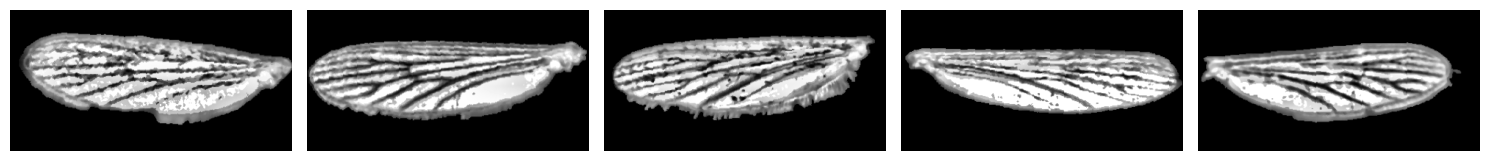

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
ax = axes.ravel()

for i in range(ax.__len__()):
    image, label = next(iter(train_dataloader))
    ax[i].imshow(image[0].squeeze(), cmap='gray')
    ax[i].axis('off')

plt.tight_layout()

In [ ]:
# Load new model
# Load the pre-trained EfficientNetB0 model
model = models.efficientnet_b0(pretrained=True)

# Modify the first convolution layer to accept a single channel
# Get the current first convolutional layer
original_conv = model.features[0][0]

# Create a new convolutional layer with 1 input channel
new_conv = nn.Conv2d(
    in_channels=1,                  # Change to 1 channel
    out_channels=original_conv.out_channels,
    kernel_size=original_conv.kernel_size,
    stride=original_conv.stride,
    padding=original_conv.padding,
    bias=original_conv.bias is not None
)

# Initialize the new conv layer weights by copying and averaging the weights from the original
with torch.no_grad():
    new_conv.weight[:] = original_conv.weight.mean(dim=1, keepdim=True)

# Replace the original convolutional layer with the new single-channel conv layer
model.features[0][0] = new_conv

# Modify the classifier to replace the classification head with a dropout and a single dense layer
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),            # Dropout layer
    nn.Linear(num_features, 21)    # Single output for binary classification
)

model = model.to(device)

In [ ]:
# Initialize Weights & Biases
wandb.init(project="phd_app_v2")
wandb.config.update({   "epochs": epochs,
                        "batch_size": batch_size,
                        "learning_rate": learning_rate,
                        "Image_size": (image_height, image_width),
                        # Manual Corrections
                        "pretrained": True,
                        "LR_Scheduler": "CosineDecay with WarmUp",
                        "model": "EfficientNetB0",
                        "optimizer": "AdamW",
                        "training_size": train_dataloader.__len__()*batch_size,
                        "comment": ""})

In [ ]:
# Define loss
ce_loss = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Define scheduler
def lr_lambda(current_epoch):
    if current_epoch < warmup_epochs:
        # Linear warm-up
        return warmup_factor + (1 - warmup_factor) * (current_epoch / warmup_epochs)
    else:
        # Cosine decay
        progress = (current_epoch - warmup_epochs) / (epochs - warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * progress))

# Create the LambdaLR scheduler
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

def train_loop(dataloader, model, epoch):
    model.train()
    total_loss = 0
    total_acc = 0
    total_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)

        pred = model(X)
        loss = ce_loss(pred, y.argmax(dim=1))
        acc = (pred.argmax(dim=1) == y.argmax(dim=1)).float().mean()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Calculate metrics
        total_loss += loss.item()
        total_acc += acc.item()

    # Average metrics for the epoch
    avg_loss = total_loss / total_batches
    acc = total_acc / total_batches

    print(f"Epoch {epoch}: Loss: {avg_loss:.3f}, Accuracy: {acc:.3f}")

    wandb.log({
        "epoch": epoch,
        "train_loss": avg_loss,
        "train_accuracy": acc,
        "learning_rate": scheduler.get_last_lr()[0]
    })

    scheduler.step()

def test_loop(dataloader, model, epoch):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_batches = len(dataloader)

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            # Compute prediction and loss
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            loss = ce_loss(pred, y.argmax(dim=1))
            acc = (pred.argmax(dim=1) == y.argmax(dim=1)).float().mean()

            # Calculate metrics
            total_loss += loss.item()
            total_acc += acc.item()

    # Average metrics for the epoch
    avg_loss = total_loss / total_batches
    acc = total_acc / total_batches

    wandb.log({
        "val_loss": avg_loss,
        "val_accuracy": acc,
    })

    print(f"Test: Loss: {avg_loss:.3f}, Accuracy: {acc:.3f}")
    print("----------------------------")

def evaluation(dataloader, model):
    predictions = []
    targets = []
    for batch, (X, y) in enumerate(dataloader):
            # Compute prediction and loss
            X = X.to(device)
            y = y.to(device)

            pred = model(X)

            predictions.append(pred.cpu().detach().numpy())
            targets.append(y.cpu().detach().numpy())

    return np.concatenate(predictions), np.concatenate(targets)

In [ ]:
# TRAIN
for t in range(epochs):
    train_loop(train_dataloader, model, t)
    test_loop(test_dataloader, model, t)

Epoch 0: Loss: 2.491, Accuracy: 0.336
Test: Loss: 2.004, Accuracy: 0.401
----------------------------
Epoch 1: Loss: 1.423, Accuracy: 0.694
Test: Loss: 1.058, Accuracy: 0.826
----------------------------
Epoch 2: Loss: 1.095, Accuracy: 0.821
Test: Loss: 0.914, Accuracy: 0.905
----------------------------
Epoch 3: Loss: 0.954, Accuracy: 0.879
Test: Loss: 0.862, Accuracy: 0.912
----------------------------
Epoch 4: Loss: 0.894, Accuracy: 0.901
Test: Loss: 0.808, Accuracy: 0.935
----------------------------
Epoch 5: Loss: 0.855, Accuracy: 0.917
Test: Loss: 0.900, Accuracy: 0.905
----------------------------
Epoch 6: Loss: 0.837, Accuracy: 0.923
Test: Loss: 0.764, Accuracy: 0.955
----------------------------
Epoch 7: Loss: 0.797, Accuracy: 0.939
Test: Loss: 0.765, Accuracy: 0.948
----------------------------
Epoch 8: Loss: 0.769, Accuracy: 0.949
Test: Loss: 0.724, Accuracy: 0.965
----------------------------
Epoch 9: Loss: 0.772, Accuracy: 0.947
Test: Loss: 0.767, Accuracy: 0.955
---------

In [ ]:
# TEST & SAVE
test_df = pd.DataFrame()
test_df["PATH"] = test_path_list

predictions, targets = evaluation(test_dataloader, model)

test_df["PRED"] = oh_encoder.inverse_transform(predictions)
test_df["TARGET"] = oh_encoder.inverse_transform(targets)

#pd.to_pickle(test_df, os.path.join(path, "results", f"test_df_{FOLD}_{wandb.run.name}.pkl"))
#torch.save(model, os.path.join(path, "models", f"model_{FOLD}_{wandb.run.name}.pt"))
#np.save(os.path.join(path, "results", f"test_results_{FOLD}_{wandb.run.name}.npy"), predictions)
wandb.finish()